In [9]:
from google.colab import drive

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import random 
import cv2

import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers
from keras.models import Sequential

In [3]:
!python --version

Python 3.9.16


In [4]:
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


In [5]:
train_path = "/content/drive/MyDrive/Alzheimer_s Dataset-2/train"
test_path = "/content/drive/MyDrive/Alzheimer_s Dataset-2/test"

In [7]:
train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,  
                                     classes = ['NonDemented', 'VeryMildDemented', 
                                                'MildDemented', 'ModerateDemented'], 
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, 
                                          classes = ['NonDemented', 'VeryMildDemented', 
                                                     'MildDemented', 'ModerateDemented'], 
                                          subset='validation',
                                          batch_size=10)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, 
                                         classes = ['NonDemented', 'VeryMildDemented', 
                                                    'MildDemented', 'ModerateDemented'], 
                                         batch_size=10, 
                                         shuffle=False)

Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


<BarContainer object of 4 artists>

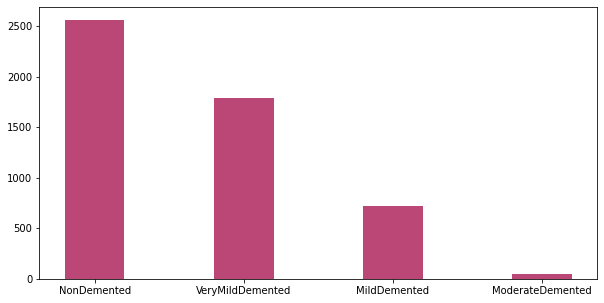

In [16]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

for cls in os.listdir(train_path):
    for img in os.listdir(train_path + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.7, 0.2, 0.4, 0.9), width = 0.4)

In [9]:
IMG_SIZE = 224
n_classes = 4

model = Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE),
                    layers.Rescaling(1./255),
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                                  padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3)),
                    layers.BatchNormalization(),
                    layers.MaxPool2D(pool_size=(2, 2)),
                    layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding = 'same'),
                    layers.BatchNormalization(),
                    layers.MaxPool2D(pool_size=(2, 2)),
                    layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                  activation='relu', padding = 'same'),
                    layers.BatchNormalization(),
                    layers.MaxPool2D(pool_size=(2, 2)),
                    layers.Conv2D(filters=256, kernel_size=(3, 3), 
                                  activation='relu', padding = 'same'),
                    layers.BatchNormalization(),
                    layers.MaxPool2D(pool_size=(2, 2)),
                    layers.Flatten(),
                    layers.Dense(300, activation='relu'),
                    layers.Dense(150, activation='relu'),
                    layers.Dropout(0.25),
                    layers.Dense(n_classes, activation='softmax')])

In [10]:
METRICS = [keras.metrics.CategoricalAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=METRICS)

In [12]:
EPOCHS = 5
BATCH_SIZE = 8

In [13]:
history = model.fit(x=train_batches,
                    validation_data=validation_batches,
                    steps_per_epoch=len(train_batches),
                    validation_steps=len(validation_batches),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    verbose=2)

Epoch 1/5
461/461 - 1167s - loss: 1.2090 - accuracy: 0.5334 - precision: 0.5835 - recall: 0.4462 - auc: 0.8011 - val_loss: 1.3309 - val_accuracy: 0.5010 - val_precision: 0.5039 - val_recall: 0.5010 - val_auc: 0.8277 - 1167s/epoch - 3s/step
Epoch 2/5
461/461 - 17s - loss: 0.6560 - accuracy: 0.7119 - precision: 0.7598 - recall: 0.6492 - auc: 0.9221 - val_loss: 0.8473 - val_accuracy: 0.5969 - val_precision: 0.6341 - val_recall: 0.5597 - val_auc: 0.8836 - 17s/epoch - 36ms/step
Epoch 3/5
461/461 - 16s - loss: 0.2477 - accuracy: 0.9141 - precision: 0.9284 - recall: 0.9004 - auc: 0.9900 - val_loss: 0.4879 - val_accuracy: 0.8082 - val_precision: 0.8184 - val_recall: 0.8023 - val_auc: 0.9591 - 16s/epoch - 35ms/step
Epoch 4/5
461/461 - 17s - loss: 0.0694 - accuracy: 0.9807 - precision: 0.9821 - recall: 0.9783 - auc: 0.9993 - val_loss: 0.2051 - val_accuracy: 0.9100 - val_precision: 0.9132 - val_recall: 0.9061 - val_auc: 0.9921 - 17s/epoch - 36ms/step
Epoch 5/5
461/461 - 17s - loss: 0.0179 - accur

In [14]:
def plot_loss(history, n):
    plt.semilogy(history.epoch, history.history['loss'], label='Train')
    plt.semilogy(history.epoch, history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

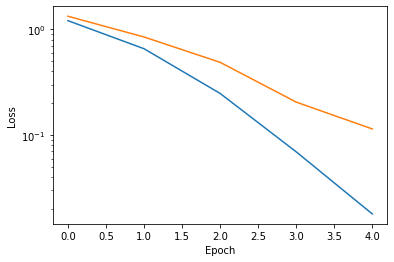

In [15]:
plot_loss(history, 0)

In [16]:
results = model.evaluate(test_batches, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

loss :  0.8791753053665161
accuracy :  0.7169663906097412
precision :  0.7318070530891418
recall :  0.6997654438018799
auc :  0.9124182462692261


In [17]:
def ECA(x):
    k_size = 3 
    squeeze = tf.reduce_mean(x,(2,3),keepdims=False)
    squeeze = tf.expand_dims(squeeze, axis=1)
    attn = layers.Conv1D(filters=1,
    kernel_size=k_size,
    padding='same',
    kernel_initializer='random_normal',
    use_bias=False)(squeeze)

    attn = tf.expand_dims(tf.transpose(attn, [0, 2, 1]), 3)
    attn = tf.math.sigmoid(attn)
    scale = x * attn
    return x * attn

In [18]:
IMG_SIZE = 224
n_classes = 4

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x4 = ECA(x3)
x5 = layers.BatchNormalization(axis=-1)(x4)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x8 = ECA(x7)
x9 = layers.BatchNormalization(axis=-1)(x8)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x12 = ECA(x11)
x13 = layers.BatchNormalization(axis=-1)(x12)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x16 = ECA(x15)
x17 = layers.BatchNormalization(axis=-1)(x16)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   


model_ECA = tf.keras.Model(inp, y)

In [19]:
model_ECA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=METRICS)

In [20]:
history_ECA = model_ECA.fit(x=train_batches,
                            validation_data=validation_batches,
                            steps_per_epoch=len(train_batches),
                            validation_steps=len(validation_batches),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE, 
                            verbose=2)

Epoch 1/5
461/461 - 26s - loss: 1.2176 - accuracy: 0.5760 - precision: 0.6362 - recall: 0.4763 - auc: 0.8237 - val_loss: 1.6909 - val_accuracy: 0.5010 - val_precision: 0.5010 - val_recall: 0.5010 - val_auc: 0.7864 - 26s/epoch - 57ms/step
Epoch 2/5
461/461 - 20s - loss: 0.7236 - accuracy: 0.6816 - precision: 0.7583 - recall: 0.5920 - auc: 0.9065 - val_loss: 0.6764 - val_accuracy: 0.7065 - val_precision: 0.7852 - val_recall: 0.6223 - val_auc: 0.9273 - 20s/epoch - 43ms/step
Epoch 3/5
461/461 - 20s - loss: 0.3903 - accuracy: 0.8406 - precision: 0.8773 - recall: 0.8143 - auc: 0.9744 - val_loss: 0.4850 - val_accuracy: 0.7750 - val_precision: 0.7850 - val_recall: 0.7573 - val_auc: 0.9583 - 20s/epoch - 44ms/step
Epoch 4/5
461/461 - 20s - loss: 0.1675 - accuracy: 0.9393 - precision: 0.9513 - recall: 0.9358 - auc: 0.9952 - val_loss: 0.1932 - val_accuracy: 0.9315 - val_precision: 0.9461 - val_recall: 0.9276 - val_auc: 0.9942 - 20s/epoch - 43ms/step
Epoch 5/5
461/461 - 20s - loss: 0.0635 - accurac

In [21]:
model_ECA.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['resizing_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)              (None, 224, 224, 32  896         ['rescaling_1[0][0]']        

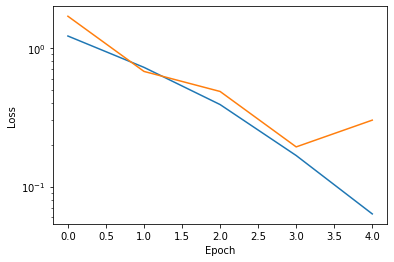

In [55]:
plot_loss(history_ECA, 0)

In [23]:
results = model_ECA.evaluate(test_batches, verbose=0)

for name, value in zip(model_ECA.metrics_names, results):
    print(name, ': ', value)

loss :  0.8863188624382019
accuracy :  0.6950742602348328
precision :  0.7086039185523987
recall :  0.6825644969940186
auc :  0.9012384414672852


In [24]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

In [25]:
IMG_SIZE = 224
n_classes = 4

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x4 = cbam_block(x3)
x5 = layers.BatchNormalization(axis=-1)(x4)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x8 = cbam_block(x7)
x9 = layers.BatchNormalization(axis=-1)(x8)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x12 = cbam_block(x11)
x13 = layers.BatchNormalization(axis=-1)(x12)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x16 = cbam_block(x15)
x17 = layers.BatchNormalization(axis=-1)(x16)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   


model_CBAM = tf.keras.Model(inp, y)

In [26]:
model_CBAM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss='categorical_crossentropy', 
                   metrics=METRICS)

In [27]:
history_CBAM = model_CBAM.fit(x=train_batches,
                              validation_data=validation_batches,
                              steps_per_epoch=len(train_batches),
                              validation_steps=len(validation_batches),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE, 
                              verbose=2)

Epoch 1/5
461/461 - 46s - loss: 1.0794 - accuracy: 0.5906 - precision: 0.6317 - recall: 0.5237 - auc: 0.8411 - val_loss: 1.3851 - val_accuracy: 0.5010 - val_precision: 0.5010 - val_recall: 0.5010 - val_auc: 0.7740 - 46s/epoch - 99ms/step
Epoch 2/5
461/461 - 36s - loss: 0.6243 - accuracy: 0.7364 - precision: 0.7708 - recall: 0.6872 - auc: 0.9304 - val_loss: 1.1085 - val_accuracy: 0.6145 - val_precision: 0.6154 - val_recall: 0.6106 - val_auc: 0.8791 - 36s/epoch - 78ms/step
Epoch 3/5
461/461 - 36s - loss: 0.3133 - accuracy: 0.8813 - precision: 0.8985 - recall: 0.8659 - auc: 0.9829 - val_loss: 0.4952 - val_accuracy: 0.7867 - val_precision: 0.7992 - val_recall: 0.7789 - val_auc: 0.9595 - 36s/epoch - 77ms/step
Epoch 4/5
461/461 - 35s - loss: 0.1634 - accuracy: 0.9403 - precision: 0.9474 - recall: 0.9341 - auc: 0.9951 - val_loss: 0.5607 - val_accuracy: 0.7593 - val_precision: 0.7709 - val_recall: 0.7573 - val_auc: 0.9542 - 35s/epoch - 77ms/step
Epoch 5/5
461/461 - 37s - loss: 0.0951 - accurac

In [28]:
model_CBAM.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_2 (Resizing)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['resizing_2[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)              (None, 224, 224, 32  896         ['rescaling_2[0][0]']      

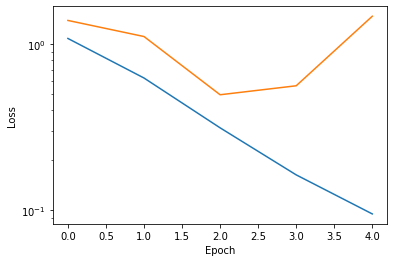

In [56]:
plot_loss(history_CBAM, 0)

In [30]:
results = model_CBAM.evaluate(test_batches, verbose=0)

for name, value in zip(model_CBAM.metrics_names, results):
    print(name, ': ', value)

loss :  1.7529840469360352
accuracy :  0.4941360354423523
precision :  0.49711933732032776
recall :  0.47224393486976624
auc :  0.769385814666748


In [31]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):

        gradModel = tf.keras.Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
                 self.model.output])
      
        with tf.GradientTape() as tape:

            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
      
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
    
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):

        heatmap = cv2.applyColorMap(heatmap, colormap)
        image = np.asarray(image, np.float64)
        heatmap = np.asarray(heatmap, np.float64)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

In [32]:
def show_heatmap(model, img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    label_to_class = {'NonDemented': 0,
                      'VeryMildDemented': 1,
                      'MildDemented': 2,
                      'ModerateDemented': 3}

    class_to_label = {v: k for k, v in label_to_class.items()}

    label = class_to_label[i]
    print(f'Predicted class: {label} | Prediction probability: {max(preds[0]) * 100}%')
    
    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(image)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image[0], alpha=0.5)
    
    output = output.astype(np.uint8)
    plt.imshow(output, interpolation='nearest')
    plt.show()

In [43]:
from tensorflow.keras.preprocessing.image import load_img

In [45]:
from tensorflow.keras.preprocessing.image import img_to_array

1/1 [==============================] - 0s 230ms/step
Predicted class: MildDemented | Prediction probability: 65.08113145828247%


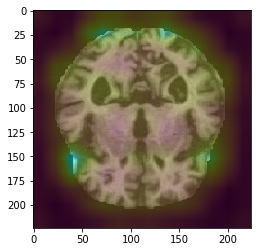

In [47]:
img_path = "/content/drive/MyDrive/Alzheimer_s Dataset-2/train/ModerateDemented/moderateDem0.jpg"
show_heatmap(model,img_path)

1/1 [==============================] - 0s 19ms/step
Predicted class: NonDemented | Prediction probability: 99.53945279121399%


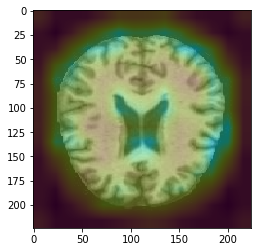

In [48]:
img_path = "/content/drive/MyDrive/Alzheimer_s Dataset-2/test/NonDemented/26 (62).jpg"
show_heatmap(model,img_path)

1/1 [==============================] - 0s 80ms/step
Predicted class: MildDemented | Prediction probability: 99.96746778488159%


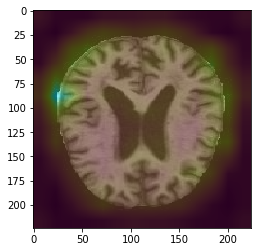

In [49]:
img_path = "/content/drive/MyDrive/Alzheimer_s Dataset-2/test/MildDemented/26 (23).jpg"
show_heatmap(model,img_path)